In [111]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from datetime import date
from datetime import datetime
from dateutil import parser
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pickle
from prophet.serialize import model_to_json, model_from_json
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_cross_validation_metric, plot_components_plotly, add_changepoints_to_plot, plot_yearly
from prophet.serialize import model_to_json, model_from_json

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
#!unzip household_power_consumption.zip

In [3]:
pd.set_option("display.float_format", "{:.2f}".format)

In [4]:
# The ds (datestamp) column should be of a format expected by Pandas,
# ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

In [5]:
df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True, low_memory=False)
del df['Sub_metering_1']
del df['Sub_metering_2']
del df['Sub_metering_3']
del df['Global_reactive_power']
del df['Voltage']
del df['Global_intensity']
df.rename(columns={'Global_active_power':'y'}, inplace = True)
df

,ds,y
0,2006-12-16 17:24:00,4.22
1,2006-12-16 17:25:00,5.36
2,2006-12-16 17:26:00,5.37
3,2006-12-16 17:27:00,5.39
4,2006-12-16 17:28:00,3.67
...,...,...
2075254,2010-11-26 20:58:00,0.95
2075255,2010-11-26 20:59:00,0.94
2075256,2010-11-26 21:00:00,0.94
2075257,2010-11-26 21:01:00,0.93


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ds      datetime64[ns]
 1   y       float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.7 MB


In [7]:
df

,ds,y
0,2006-12-16 17:24:00,4.22
1,2006-12-16 17:25:00,5.36
2,2006-12-16 17:26:00,5.37
3,2006-12-16 17:27:00,5.39
4,2006-12-16 17:28:00,3.67
...,...,...
2075254,2010-11-26 20:58:00,0.95
2075255,2010-11-26 20:59:00,0.94
2075256,2010-11-26 21:00:00,0.94
2075257,2010-11-26 21:01:00,0.93


In [8]:
df.head(15)

,ds,y
0,2006-12-16 17:24:00,4.22
1,2006-12-16 17:25:00,5.36
2,2006-12-16 17:26:00,5.37
3,2006-12-16 17:27:00,5.39
4,2006-12-16 17:28:00,3.67
5,2006-12-16 17:29:00,3.52
6,2006-12-16 17:30:00,3.70
7,2006-12-16 17:31:00,3.70
8,2006-12-16 17:32:00,3.67
9,2006-12-16 17:33:00,3.66


### Model

In [13]:
df['time_bin']=pd.cut(df['ds'].dt.hour, bins=3, labels=False)

In [14]:
time_oh=pd.get_dummies(df['time_bin'], prefix='tbin')

In [15]:
df=df.join(time_oh)

In [16]:
df

,ds,y,time_bin,tbin_0,tbin_1,tbin_2
0,2006-12-16 17:24:00,4.22,2,0,0,1
1,2006-12-16 17:25:00,5.36,2,0,0,1
2,2006-12-16 17:26:00,5.37,2,0,0,1
3,2006-12-16 17:27:00,5.39,2,0,0,1
4,2006-12-16 17:28:00,3.67,2,0,0,1
...,...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.95,2,0,0,1
2075255,2010-11-26 20:59:00,0.94,2,0,0,1
2075256,2010-11-26 21:00:00,0.94,2,0,0,1
2075257,2010-11-26 21:01:00,0.93,2,0,0,1


In [18]:
df_final=df[['ds', 'y', 'tbin_0', 'tbin_1', 'tbin_2']]

In [19]:
df_final

,ds,y,tbin_0,tbin_1,tbin_2
0,2006-12-16 17:24:00,4.22,0,0,1
1,2006-12-16 17:25:00,5.36,0,0,1
2,2006-12-16 17:26:00,5.37,0,0,1
3,2006-12-16 17:27:00,5.39,0,0,1
4,2006-12-16 17:28:00,3.67,0,0,1
...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.95,0,0,1
2075255,2010-11-26 20:59:00,0.94,0,0,1
2075256,2010-11-26 21:00:00,0.94,0,0,1
2075257,2010-11-26 21:01:00,0.93,0,0,1


In [66]:
train=df_final[(df_final['ds'] >= '2010-01-01') & (df_final['ds'] < '2010-11-01 00:00:00')]
test=df_final[(df_final['ds'] >= '2010-11-01 00:00:00')]

In [67]:
train.shape

(437760, 5)

In [68]:
test.shape

(37263, 5)

In [69]:
train

,ds,y,tbin_0,tbin_1,tbin_2
1600236,2010-01-01 00:00:00,1.79,1,0,0
1600237,2010-01-01 00:01:00,1.78,1,0,0
1600238,2010-01-01 00:02:00,1.78,1,0,0
1600239,2010-01-01 00:03:00,1.75,1,0,0
1600240,2010-01-01 00:04:00,1.69,1,0,0
...,...,...,...,...,...
2037991,2010-10-31 23:55:00,2.46,0,0,1
2037992,2010-10-31 23:56:00,2.41,0,0,1
2037993,2010-10-31 23:57:00,1.36,0,0,1
2037994,2010-10-31 23:58:00,1.37,0,0,1


In [70]:
test

,ds,y,tbin_0,tbin_1,tbin_2
2037996,2010-11-01 00:00:00,1.37,1,0,0
2037997,2010-11-01 00:01:00,1.37,1,0,0
2037998,2010-11-01 00:02:00,1.37,1,0,0
2037999,2010-11-01 00:03:00,1.31,1,0,0
2038000,2010-11-01 00:04:00,1.27,1,0,0
...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.95,0,0,1
2075255,2010-11-26 20:59:00,0.94,0,0,1
2075256,2010-11-26 21:00:00,0.94,0,0,1
2075257,2010-11-26 21:01:00,0.93,0,0,1


In [88]:
m = Prophet()

In [73]:
m.fit(train)

12:55:57 - cmdstanpy - INFO - Chain [1] start processing
12:58:58 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
future = m.make_future_dataframe(periods = 130, freq = 'H')
future.tail(50)

,ds
437840,2010-11-04 08:59:00
437841,2010-11-04 09:59:00
437842,2010-11-04 10:59:00
437843,2010-11-04 11:59:00
437844,2010-11-04 12:59:00
437845,2010-11-04 13:59:00
437846,2010-11-04 14:59:00
437847,2010-11-04 15:59:00
437848,2010-11-04 16:59:00
437849,2010-11-04 17:59:00


In [75]:
future = m.make_future_dataframe(periods = 312, freq = 'H')
future.tail(50)

,ds
438022,2010-11-11 22:59:00
438023,2010-11-11 23:59:00
438024,2010-11-12 00:59:00
438025,2010-11-12 01:59:00
438026,2010-11-12 02:59:00
438027,2010-11-12 03:59:00
438028,2010-11-12 04:59:00
438029,2010-11-12 05:59:00
438030,2010-11-12 06:59:00
438031,2010-11-12 07:59:00


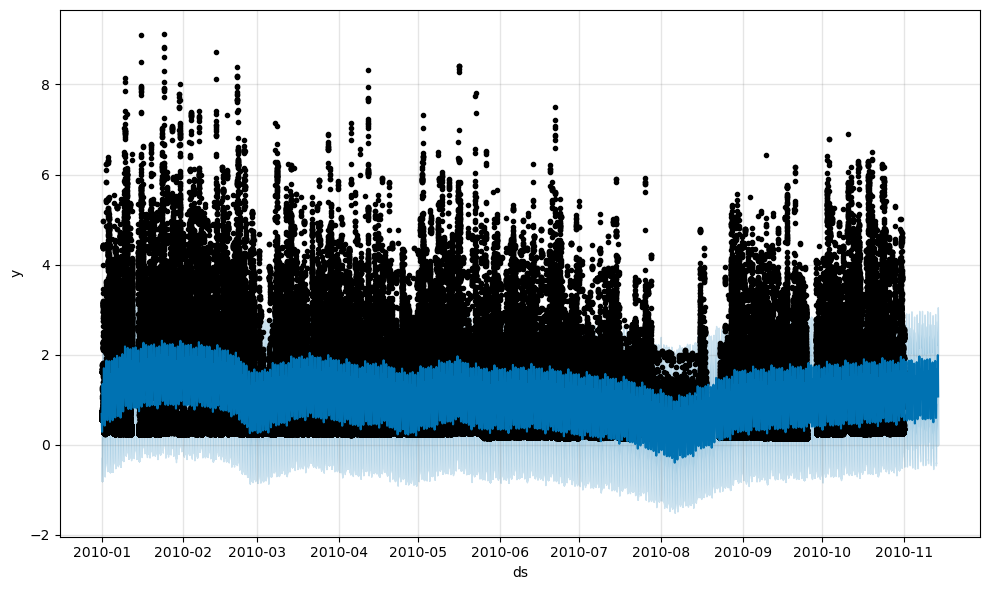

In [60]:
fcst = m.predict(future)
fig = m.plot(fcst)

In [76]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
438052,2010-11-13 04:59:00,0.64,-0.42,1.74
438053,2010-11-13 05:59:00,0.87,-0.15,1.86
438054,2010-11-13 06:59:00,1.23,0.22,2.25
438055,2010-11-13 07:59:00,1.55,0.50,2.59
438056,2010-11-13 08:59:00,1.67,0.62,2.73
438057,2010-11-13 09:59:00,1.60,0.49,2.65
438058,2010-11-13 10:59:00,1.48,0.40,2.51
438059,2010-11-13 11:59:00,1.43,0.31,2.52
438060,2010-11-13 12:59:00,1.46,0.38,2.65
438061,2010-11-13 13:59:00,1.46,0.43,2.56


### 5:00 - 9:00

In [77]:
future_final = future.copy()
future_final = future_final[future_final['ds'].dt.hour > 3][future_final['ds'].dt.hour < 9]

C:\Users\pauli\AppData\Local\Temp\ipykernel_12256\1351967405.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [78]:
future_final.tail(50)

,ds
437836,2010-11-04 04:59:00
437837,2010-11-04 05:59:00
437838,2010-11-04 06:59:00
437839,2010-11-04 07:59:00
437840,2010-11-04 08:59:00
437860,2010-11-05 04:59:00
437861,2010-11-05 05:59:00
437862,2010-11-05 06:59:00
437863,2010-11-05 07:59:00
437864,2010-11-05 08:59:00


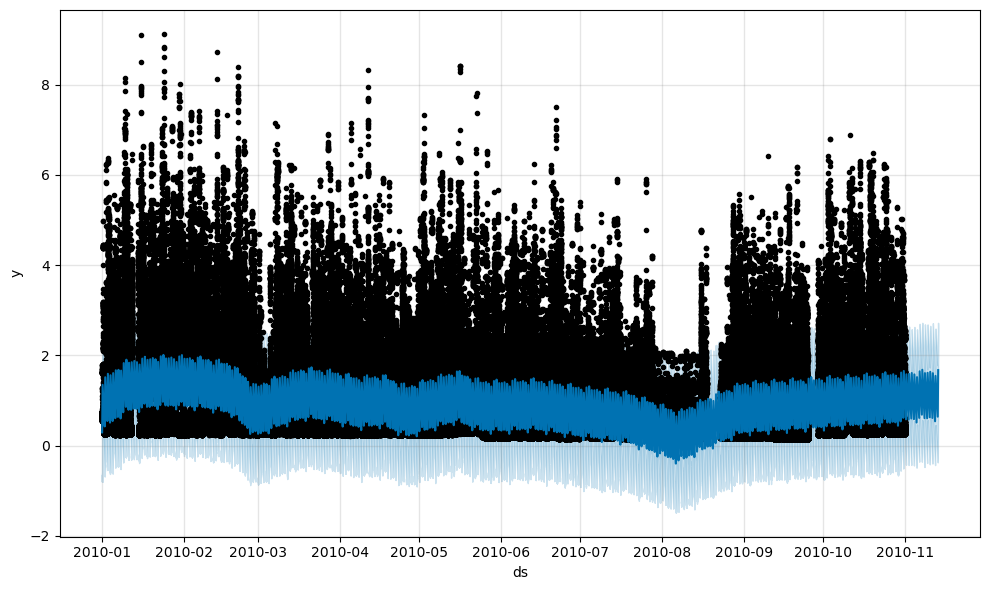

In [79]:
fcst = m.predict(future_final)
fig = m.plot(fcst)

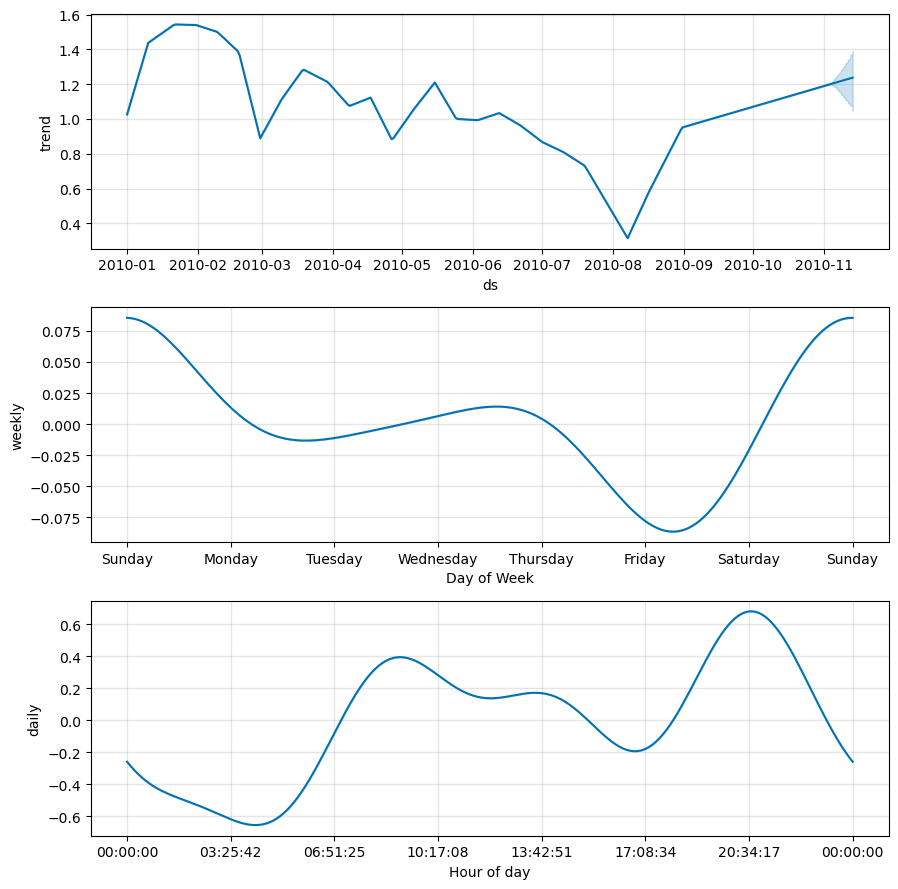

In [80]:
fig2 = m.plot_components(fcst)

In [81]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
91245,2010-11-10 04:59:00,0.63,-0.42,1.73
91246,2010-11-10 05:59:00,0.85,-0.18,1.91
91247,2010-11-10 06:59:00,1.20,0.19,2.26
91248,2010-11-10 07:59:00,1.51,0.53,2.59
91249,2010-11-10 08:59:00,1.63,0.64,2.65
91250,2010-11-11 04:59:00,0.61,-0.40,1.60
91251,2010-11-11 05:59:00,0.83,-0.25,1.88
91252,2010-11-11 06:59:00,1.18,0.14,2.17
91253,2010-11-11 07:59:00,1.49,0.46,2.54
91254,2010-11-11 08:59:00,1.60,0.60,2.71


### 18:00 - 22:00

In [83]:
future_final_2 = future.copy()
future_final_2 = future_final_2[future_final_2['ds'].dt.hour > 16][future_final_2['ds'].dt.hour < 22]

C:\Users\pauli\AppData\Local\Temp\ipykernel_12256\427137905.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [84]:
future_final_2.tail(50)

,ds
437849,2010-11-04 17:59:00
437850,2010-11-04 18:59:00
437851,2010-11-04 19:59:00
437852,2010-11-04 20:59:00
437853,2010-11-04 21:59:00
437873,2010-11-05 17:59:00
437874,2010-11-05 18:59:00
437875,2010-11-05 19:59:00
437876,2010-11-05 20:59:00
437877,2010-11-05 21:59:00


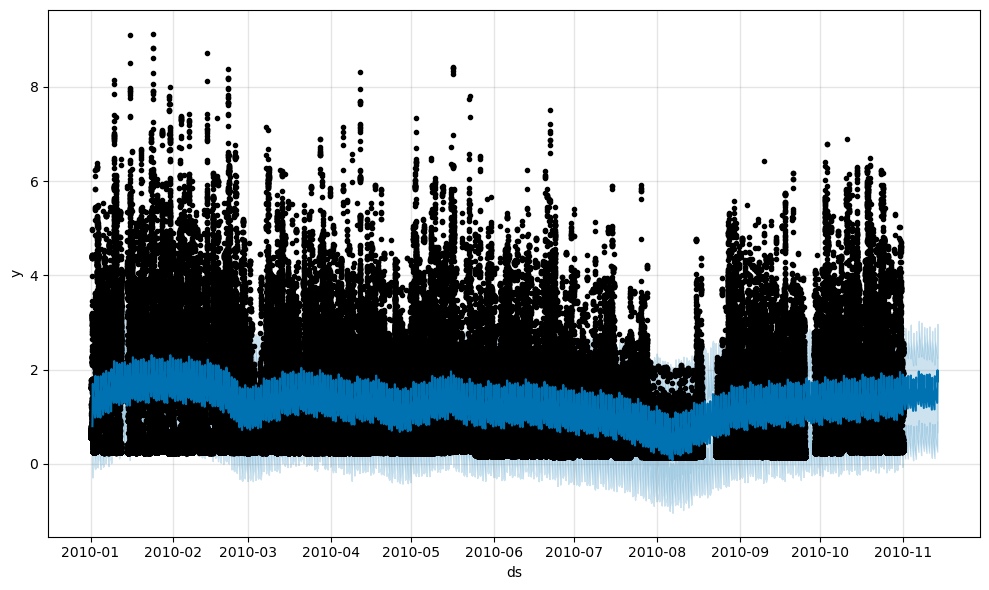

In [85]:
fcst_2 = m.predict(future_final_2)
fig = m.plot(fcst_2)

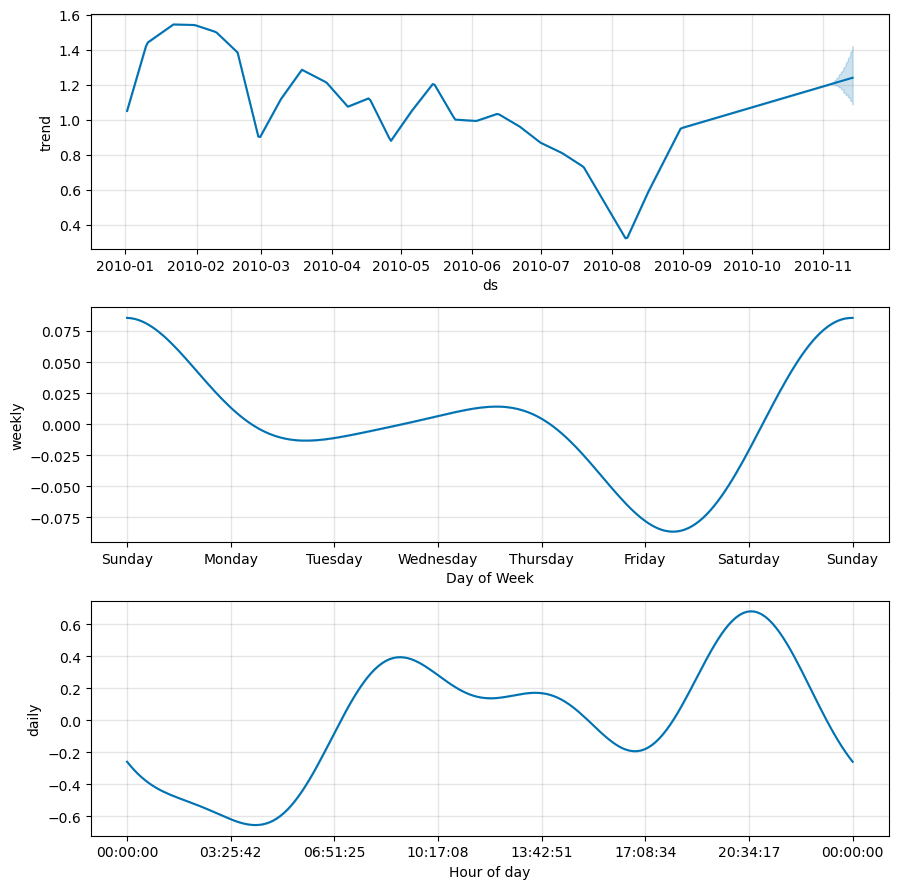

In [86]:
fig3 = m.plot_components(fcst_2)

In [87]:
fcst_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
91245,2010-11-10 17:59:00,1.22,0.24,2.23
91246,2010-11-10 18:59:00,1.56,0.52,2.58
91247,2010-11-10 19:59:00,1.85,0.81,2.89
91248,2010-11-10 20:59:00,1.90,0.88,2.92
91249,2010-11-10 21:59:00,1.66,0.72,2.68
91250,2010-11-11 17:59:00,1.15,0.13,2.18
91251,2010-11-11 18:59:00,1.49,0.41,2.55
91252,2010-11-11 19:59:00,1.78,0.72,2.82
91253,2010-11-11 20:59:00,1.83,0.84,2.82
91254,2010-11-11 21:59:00,1.59,0.56,2.61
